<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>

</center>

# [Scénarios d'Apprentissage Statistique](https://github.com/wikistat/Apprentissage)

# Adaptation Statistique d'un Modèle de Prévision du Pic d'Ozone en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="Scikit-learn"/></a>

**Résumé**: Exploration puis modélisation de données climatiques en utilisant Python et la librairie [Scikit-learn](http://scikit-learn.org/stable/#). L'objectif est de prévoir pour le lendemain un possible dépassement d'un seuil de concentration en ozone à partir d'une prévision déterministe sur un maillage grossier et de variables climatiques locales. Estimation par différentes méthodes: régression [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [k plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [agrégation de modèle](http://wikistat.fr/pdf/st-m-app-agreg.pdf), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf). Comparaison des [erreurs de prévision](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf) sur un échantillon test puis des courbes ROC. Itération sur plusieurs échantillons tests pour analyser la distribution de l'erreur de prévision. Ce calepin vient compléter l'[étude faite avec R](http://www.math.univ-toulouse.fr/~besse/Wikistat/Notebooks/Notebook-R-Ozone.html) pour en comparer les deux approches.

**Avertissement** 

* Ce calepin complète [celui en R](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-R-Ozone.ipynb) afin de comparer les performances respectives des deux environnements: complétude des résultats et efficacité du code. Les explications sont plus sommaires dans ce tutoriel qui est en principe exécuté *après* ou parallèlement à celui réalisé en R.
* Comme pour R il est *découpé en 5 séances* de travaux dirigés *syncronisées* avec le cours d'apprentissage automatique. 
* Réfléchir aux réponses aux questions marquées **Q** issues du sujet d'examen.
* Toutes les options n'ont pas été testées et certaines sont posées en **exercice**.

## Introduction

L'objectif, sur ces données, est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de MétéoFrance,  de la concentration d'ozone dans certaines stations de prélèvement.  Il s'agit d'un problème dit d'*adaptation statistique* ou post-traitement d'une prévision locale de modèles à trop grande échelle en s'aidant d'autre variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent...). 

La question posée reste: quelle est la meilleure stratégie pour prévoir l'occurrence d'un pic de pollution. 

Comme avec R différentes méthodes sont testées : régression logistique, k plus proches voisins, arbre de décision, random forest, SVM. De façon générale on suppose que l'utilisateur dispose d'une installation python à jour. Le calepin a été testé avec la version 3.8.

**Question subsidiaire** quand préférer R ou Python ? Python conduit a des résultats (conclusions) identiques à ceux de R, moins complets pour leur interprétation, mais plus rapidement. Il s'agit des principales différences entre R pour "statisticien" et python pour "informaticien", on perd en interprétabilité mais on gagne en vitesse d'exécution. 

# <FONT COLOR="Red">Épisode 1</font>

## Prise en compte des données

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes:


* **JOUR** Le type de jour ; férié (1) ou pas (0) ;
* **O3obs** La concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** Prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** Température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** Rapport d'humidité ;
* **NO2** Concentration en dioxyde d'azote ;
* **NO** Concentration en monoxyde d'azote ;
* **STATION** Lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** Force du vent ;
* **VentANG** Orientation du vent. 

Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent avant tout un caractère pédagogique.

Il est choisi ici de lire les données avec la librairie `pandas` pour bénéficier de la classe DataFrame. Ce n'est pas nécessaire pour l'objectif de prévision car les variables qualitatives ainsi construites ne peuvent être utilisées pour l'interprétation des modèles obtenus dans `scikit-learn` qui ne reconnaît pas la classe DataFrame.

In [57]:
import pandas as pd
import numpy as np
# Lecture des données
## Charger les données ou les lire directement en précisant le chemin
path=""
ozone=pd.read_csv(path+"depSeuil.dat",sep=",",header=0)
# Vérification du contenu
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
0,1,91,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
1,1,100,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
2,0,82,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
3,0,94,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
4,0,107,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822


Ce qui suit permet d'affecter le bon type aux variables.

In [59]:
ozone["STATION"]=pd.Categorical(ozone["STATION"],ordered=False)
ozone["JOUR"]=pd.Categorical(ozone["JOUR"],ordered=False)
ozone["O3obs"]=pd.DataFrame(ozone["O3obs"], dtype=float)
ozone.dtypes

JOUR       category
O3obs       float64
MOCAGE      float64
TEMPE       float64
RMH2O       float64
NO2         float64
NO          float64
STATION    category
VentMOD     float64
VentANG     float64
dtype: object

In [3]:
ozone.describe()

,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,VentMOD,VentANG
count,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000
mean,115.400576,127.219693,23.883381,0.010251,3.504645,0.657417,5.907186,0.163111
std,40.999155,39.820186,5.217462,0.003731,4.043308,0.844180,3.054307,0.708288
min,19.000000,46.400000,10.400000,0.002850,0.258000,0.001000,0.141420,-1.570790
25%,87.000000,97.500000,20.200000,0.007630,1.248000,0.236000,3.962320,-0.394790
50%,109.000000,125.600000,23.800000,0.009850,2.109000,0.388000,5.597300,0.278300
75%,135.000000,153.600000,27.600000,0.012440,4.062000,0.744000,7.106300,0.692640
max,319.000000,284.700000,38.000000,0.027530,44.396000,9.429000,19.891000,1.570790


## Exploration

Même si les données ne présentent pas de défauts particuliers, une étude exploratoire préliminaire est indispensable afin de s'assurer le leur bonne cohérence, proposer d'éventuelles transformations et analyser les structures de corrélations ou plus généralement de liaisons entre les variables, de groupes des individus ou observations.

### Unidimensionnelle

In [4]:
%matplotlib inline

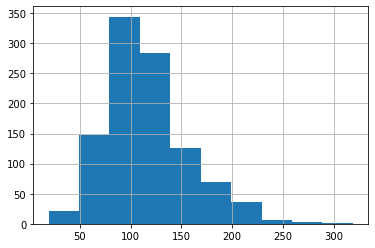

In [5]:
import matplotlib.pyplot as plt
ozone["O3obs"].hist()
plt.show()

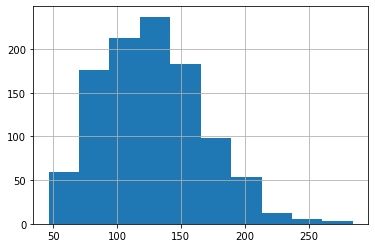

In [6]:
ozone["MOCAGE"].hist()
plt.show()

**Exercice** Traiter ainsi toutes les variables. Ceci suggère des transformations pour une meilleure utilisation des modèles linéaires. 

In [7]:
from math import sqrt, log
ozone["SRMH2O"]=ozone["RMH2O"].map(lambda x: sqrt(x))
ozone["LNO2"]=ozone["NO2"].map(lambda x: log(x))
ozone["LNO"]=ozone["NO"].map(lambda x: log(x))
del ozone["RMH2O"]
del ozone["NO2"]
del ozone["NO"]

**Exercice** Vérifier l'opportunité de ces transformations (histogrammes des nouvelles variables).

Retirer les variables initiales et construire ci-dessous la variable "dépassement de seuil" pour obtenir le fichier qui sera effectivement utilisé.

In [8]:
ozone["DepSeuil"]=ozone["O3obs"].map(lambda x: x > 150)
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
0,1,91.0,93.2,21.5,Aix,9.5000,-0.64350,0.092033,0.471253,-0.858022,False
1,1,100.0,104.6,20.2,Aix,8.0100,-0.04996,0.093862,0.751888,-0.632993,False
2,0,82.0,103.6,17.4,Aix,9.3771,-0.12832,0.097519,0.505009,-0.761426,False
3,0,94.0,94.8,18.8,Aix,9.4578,-0.34516,0.092466,0.854415,-0.355247,False
4,0,107.0,99.0,23.7,Aix,7.8791,-0.41822,0.085499,0.502592,-0.794073,False


### Exploration multidimensionnelle

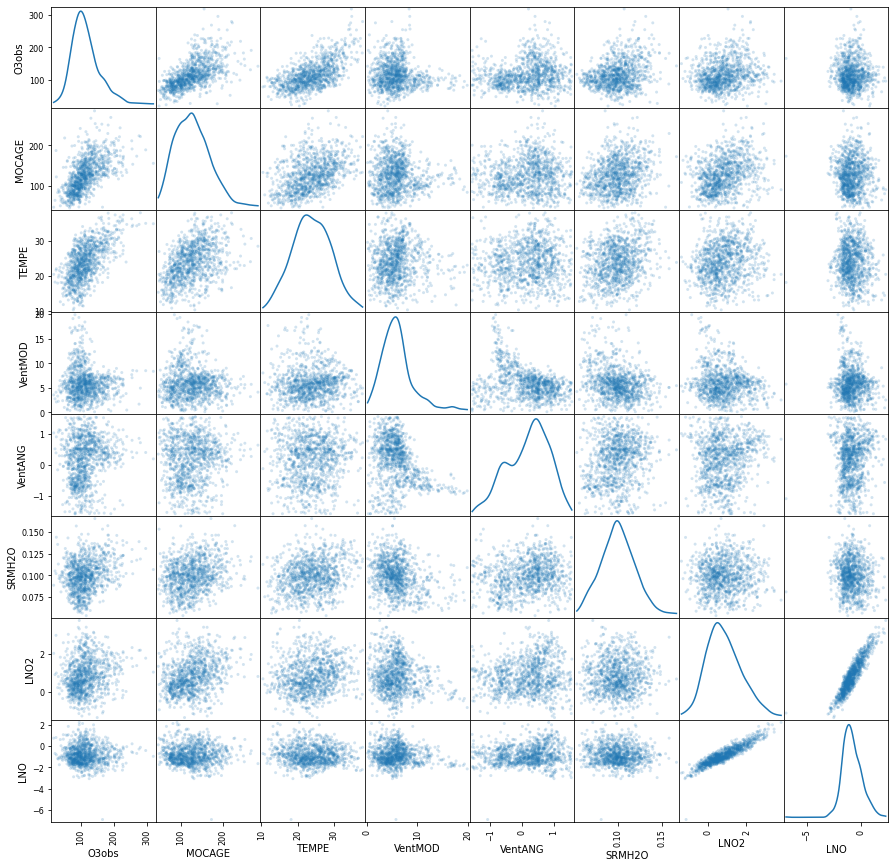

In [9]:
# scatter plot matrix des variables quantitatives
from pandas.plotting import scatter_matrix
scatter_matrix(ozone[["O3obs","MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

**Q** Commenter les relations entre les variables prises 2 à 2.

### [Analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf)

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
# réduction des variables
X=scale(ozone[["O3obs","MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]])

Tous les résultats numétriques classiques sont fournis par l'[implémentation](http://scikit-learn.org/stable/modules/decomposition.html) de scikit-learn mais des  efforts sont à produire pour construire les graphiques usuels généralement automatiquement produits par des librairies dédiées comme [FactoMineR](http://factominer.free.fr/) de R.

Les commandes suivantes permettent de réaliser une analyse en composantes principales sur les seules variables quantitatives. Par ailleurs la variable à modéliser  (O3obs, concentration observée) n'est pas utilisée.

AttributeError: module 'matplotlib.pyplot' has no attribute 'barplot'

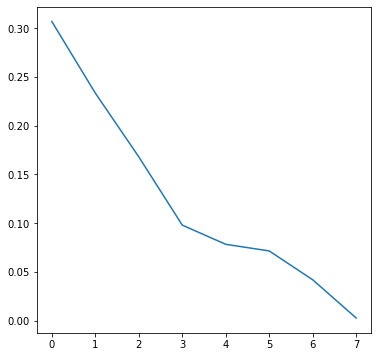

In [61]:
pca = PCA()
## Estimation, calcul des composantes principales
C = pca.fit(X).transform(X)
## Décroissance de la variance expliquée
plt.plot(pca.explained_variance_ratio_)
plt.show()

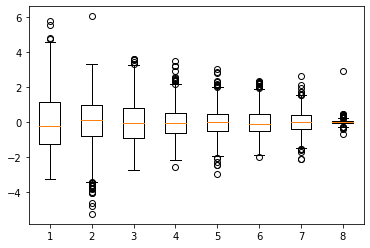

In [12]:
## distribution des composantes principales
plt.boxplot(C[:,0:20])
plt.show()

**Q** Commenter ces résultats: quel choix de la dimension? 

**Q** Présence de valeurs atypiques.

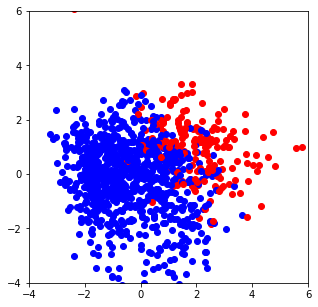

In [13]:
## Repésentation des individus
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], ozone["DepSeuil"]):
    color = "red" if nom  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

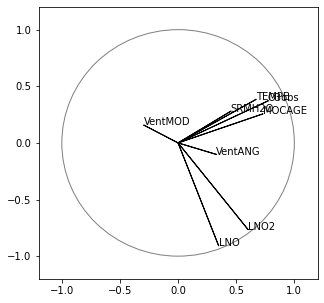

In [14]:
## coordonnées et représentation des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, ozone[["O3obs","MOCAGE","TEMPE","VentMOD",
                                           "VentANG","SRMH2O","LNO2","LNO"]].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.show()

**Q** Commenter la structure de corrélation des variables.

**Q** L'objectif est de définir une surface séparant les deux classes. Une discriminaiton linéaire (hyperplan) semble-t-elle possible?    

Ce n'est pas utile ici mais une classification non supervisée est facile à obtenir à titre illustratif, par exemple en 4 classes, par l'algorithme k-means:

In [15]:
from sklearn.cluster  import  KMeans
from  sklearn.metrics  import confusion_matrix
clust=KMeans(n_clusters=4)
clust.fit(X)
classe=clust.labels_
print(classe)

[2 2 2 ... 1 3 3]


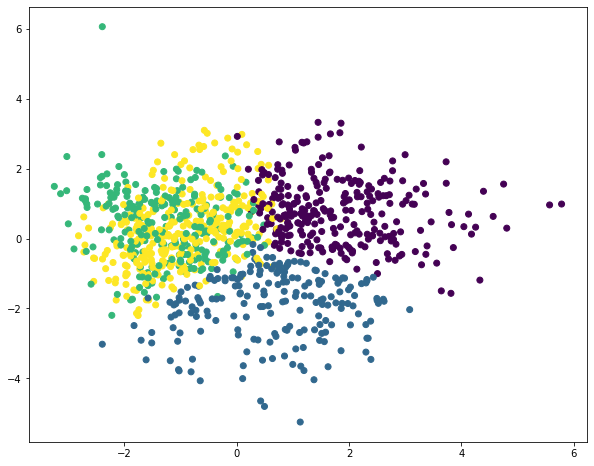

In [16]:
## Repésentation des individus dans les coordonnées de l'acp.
plt.figure(figsize=(10,8))
plt.scatter(C[:,0], C[:,1], c=classe) 
plt.show()

## Modélisations

La recherche  d'une meilleure méthode de prévision suit généralement le protocole suivant dont la première étape est déja réalisée.


1. Etape descriptive préliminaire uni et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou *features* spécifiques des données. 
2. Procéder à un tirage aléatoire d'un échantillon *test* qui ne sera utilisé que lors de la *dernière étape* de comparaison des méthodes.
3. La partie restante est l'échantillon d'*apprentissage* pour l'estimation des paramètres des modèles.
4. Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par [*validation croisée*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf).
    - Variables et interactions à prendre en compte dans la régression linéaire ou logistique;
    - variables et méthode pour l'analyse discriminante;
    - nombre de feuilles dans l'arbre de régression ou de classification;
    - architecture (nombre de neurones, pénalisation) du perceptron;
    - algorithme d'agrégation, 
    - noyau et pénalisation des SVMs.
5.  Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.

**Remarques**
* En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test ([validation croisée *Monte Carlo*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf)), afin de réduire la variance (moyenne) des estimations des erreurs de prévision.
* *Attention*: ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test !
* Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...
* L'étape "choix" de la meilleure méthode peut être remplacée par une combinaisons de prévision comme c'est souvent le cas dans les soutions "gagnantes" mais lourdes du site [kaggle](https://www.kaggle.com/competitions).

### Extraction des échantillons apprentissage et test

Transformation des données pour l'apprentissage. 

**Q** Pourquoi les variables qualitatives sont-elles transformées en paquets d'indicatrices ou *dummy variables*?

**Q** Pourquoi le type data frame est transformé en une matrice. 

In [17]:
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
0,1,91.0,93.2,21.5,Aix,9.5000,-0.64350,0.092033,0.471253,-0.858022,False
1,1,100.0,104.6,20.2,Aix,8.0100,-0.04996,0.093862,0.751888,-0.632993,False
2,0,82.0,103.6,17.4,Aix,9.3771,-0.12832,0.097519,0.505009,-0.761426,False
3,0,94.0,94.8,18.8,Aix,9.4578,-0.34516,0.092466,0.854415,-0.355247,False
4,0,107.0,99.0,23.7,Aix,7.8791,-0.41822,0.085499,0.502592,-0.794073,False


In [18]:
# Variables explicatives
ozoneDum=pd.get_dummies(ozone[["JOUR","STATION"]])
del ozoneDum["JOUR_0"]
ozoneQuant=ozone[["MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]]
dfC=pd.concat([ozoneDum,ozoneQuant],axis=1)
dfC.head()

,JOUR_1,STATION_Aix,STATION_Als,STATION_Cad,STATION_Pla,STATION_Ram,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,1,1,0,0,0,0,93.2,21.5,9.5000,-0.64350,0.092033,0.471253,-0.858022
1,1,1,0,0,0,0,104.6,20.2,8.0100,-0.04996,0.093862,0.751888,-0.632993
2,0,1,0,0,0,0,103.6,17.4,9.3771,-0.12832,0.097519,0.505009,-0.761426
3,0,1,0,0,0,0,94.8,18.8,9.4578,-0.34516,0.092466,0.854415,-0.355247
4,0,1,0,0,0,0,99.0,23.7,7.8791,-0.41822,0.085499,0.502592,-0.794073


In [19]:
# variable à expliquer binaire
Yb=ozone["DepSeuil"].map(lambda x: int(x))
# variable à expliquer réelle
Yr=ozone["O3obs"]

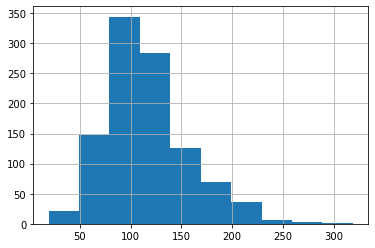

In [20]:
Yr.hist()
plt.show()

Extractions des échantillons d'apprentissage  et test pour les deux types de modèles. Comme le générateur est initalisé de façon identique, ce sont les mêmes échantillons dans les deux cas.

In [21]:
from sklearn.model_selection import train_test_split  
X_train,X_test,Yb_train,Yb_test=train_test_split(dfC,Yb,test_size=200,random_state=11)
X_train,X_test,Yr_train,Yr_test=train_test_split(dfC,Yr,test_size=200,random_state=11)

L'étape suivante est une étape de standardisation des données ou normalisation. Les variables sont divisées par leur écart-type. Ce n'est pas utile dans le cas d'un modèle linéaire élémentaire car la solution est identique mais indispensbale pour beaucoup d'autres méthodes non linéaires (SVM, réseaux de neurones, modèles avec pénalisation). Cette étape est donc concrètement systématiquement exécutée pour éviter des soucis. *Attention*, les mêmes paramètres  (moyennes, écarts-types) estimés sur l'échantillon d'apprentissage sont utilisés pour normaliser l'échantillon test. 

In [22]:
from sklearn.preprocessing import StandardScaler  
# L'algorithme ds réseaux de neurones nécessite éventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.transform(X_train)  
# Meme transformation sur le test
Xr_test = scaler.transform(X_test)

### Modèles linéaires

Les fonctions de modéles linéaires et linéaires généralisées sont limitées dans [Scikit-learn](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) et sans sorties numériques (tests) détaillées qui sont à rechercher dans une autre librairie ([StatsModels](http://statsmodels.sourceforge.net/stable/examples/notebooks/generated/glm.html)). Dans les deux cas, les stratégies classiques (forward, backward, stepwise, Furnival et Wilson) de sélection de variables par optimisation d'un critère (Cp, AIC, BIC) ne semblent pas disponibles, même si AIC et BIC sont présents dans scikit-learn, et le type DataFrame (package *pandas*) n'est pas reconnu.

La façon efficace de procéder est donc d'introduire une [pénalisation Lasso](http://wikistat.fr/pdf/st-m-app-select.pdf) pour opérer une sélection de variables ou plutôt la sélection de variables quantitatives et d'indicatrices des modalités de celles qualitatives mais sans analyse fine des interactions comme cela est possible avec R.

**Q** Quel autre type de pénalisation est aussi utilisée en régression?

**Q** Quelle la méthode qui combine les deux?

A titre de comparaison, on trace la prévision de la concentration de l'échantillon test par la seule valeur du modèle *Mocage* ainsi que les résidus à ce modèle fonction de la valeur prédite (Mocage)

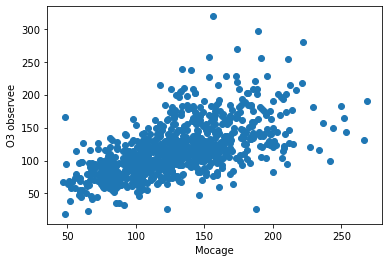

In [23]:
plt.plot(X_train["MOCAGE"],Yr_train,"o")
plt.xlabel("Mocage")
plt.ylabel("O3 observee")
plt.show()

In [24]:
from sklearn.metrics import r2_score
print("R2=",r2_score(Yr_train,X_train["MOCAGE"]))

R2= 0.12906466959137597


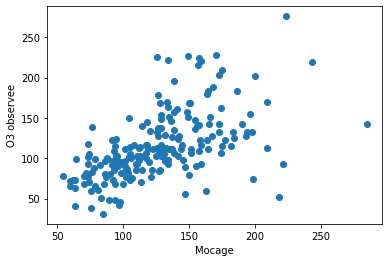

In [25]:
plt.plot(X_test["MOCAGE"],Yr_test,"o")
plt.xlabel("Mocage")
plt.ylabel("O3 observee")
plt.show()

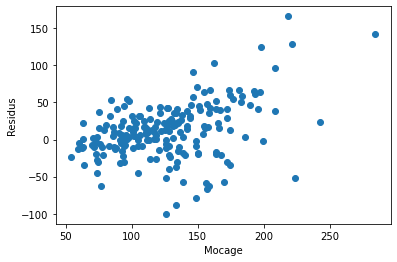

In [26]:
plt.plot(X_test["MOCAGE"],X_test["MOCAGE"]-Yr_test,"o")
plt.xlabel("Mocage")
plt.ylabel("Residus")
plt.show()

**Q** Commenter la qualité de ces résidus.

In [27]:
# Erreur quadratique moyenne
from sklearn.metrics import mean_squared_error
print("MSE=",mean_squared_error(X_test["MOCAGE"],Yr_test))

MSE= 1565.8692999999998


In [28]:
# Le coefficient de détermination 
# peut être négatif en prévision avec un mauvais modèle, 
# est nul si la prévision est constante égale à la moyennne
from sklearn.metrics import r2_score
print("R2=",r2_score(Yr_test,X_test["MOCAGE"]))

R2= 0.10558547943620222


#### [Régression linéaire](http://wikistat.fr/pdf/st-m-app-select.pdf) ou modèle gaussien

Comparer cette prévision déterministe (équation de Navier et Stockes) par l'adaptation statistique la plus élémentaire. Il s'agit d'une régression avec choix de modèle par régularisation avec une pénalisation lasso. 

**Q** Quelles est la valeur par défaut du paramètre de pénalisation Lasso?.

In [29]:
from sklearn import linear_model
regLasso = linear_model.Lasso()
regLasso.fit(Xr_train,Yr_train)
prev=regLasso.predict(Xr_test)
print("MSE=",mean_squared_error(Yr_test,prev))

MSE= 867.3885650238514


In [30]:
from sklearn.metrics import r2_score
print("R2=",r2_score(Yr_test,prev))

R2= 0.5045532040711644


Le paramètre de pénalisation lasso est optimisé par validation croisée.

In [31]:
from sklearn.model_selection import GridSearchCV
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0.05,0.1,0.2,0.3,0.4,0.5,1]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, Yr_train)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

Meilleur R2 = 0.527735, Meilleur paramètre = {'alpha': 0.4}


**Q** Quelle validation croisée est exécutée?

Prévision avec la valeur optimale de `alpha` puis calcul et tracé des résidus.

In [32]:
prev=regLassOpt.predict(Xr_test)
print("MSE=",mean_squared_error(prev,Yr_test))
print("R2=",r2_score(Yr_test,prev))

MSE= 858.2603770414801
R2= 0.5097671666144423


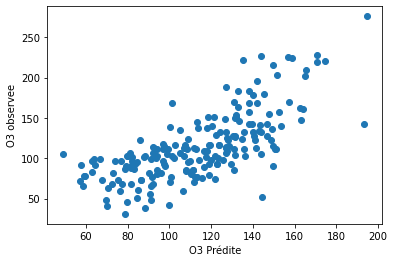

In [33]:
plt.plot(prev,Yr_test,"o")
plt.xlabel(u"O3 Prédite")
plt.ylabel("O3 observee")
plt.show()

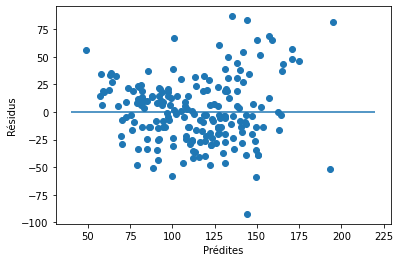

In [34]:
plt.plot(prev,Yr_test-prev,"o")
plt.xlabel(u"Prédites")
plt.ylabel(u"Résidus")
plt.hlines(0,40,220)
plt.show()

**Q** Comparer ces résidus avec ceux précédents (mocage) et noter l'amélioration. 

**Q** Commenter la forme du nuage et donc la validité du modèle. 

L'interprétation nécessite de connaître les valeurs des coefficients du modèle alors que l'objet `regLassOpt` issu de `GridSearchCV` ne retient pas les paramètres estimés. Il faut donc le ré-estimer avec la valeur optimale du paramètre de pénalisation si l'on souhaite afficher ces coefficients.

In [35]:
# Coefficients
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso=regLasso.fit(Xr_train,Yr_train)
model_lasso.coef_

array([ 0.        , -0.79659574, -0.80399572,  2.61434774,  6.32222324,
        0.        , 12.14573073, 19.96547215, -3.22355361,  2.63831358,
        1.95309275, -0.        ,  1.89595806])

In [36]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 10 variables et en supprime 3


Text(0.5, 1.0, 'Coefficients du modèle lasso')

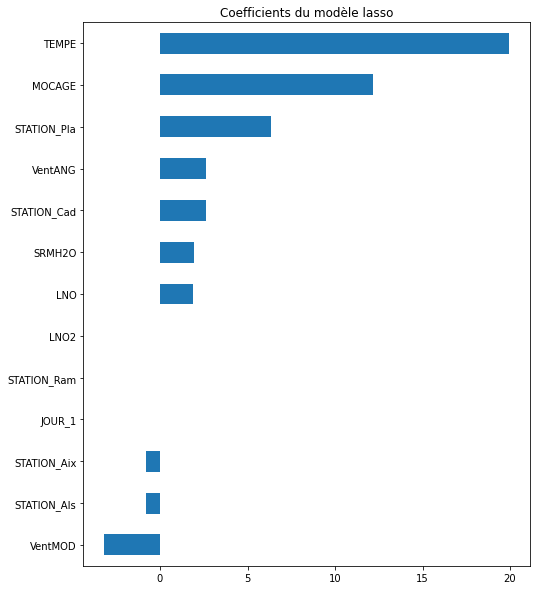

In [37]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

**Q** Noter les conséquences de la pénalisation; interpréter l'effet de chaque variable sur la concentration en ozone.

C'est ici qu'apparaît une insuffisance de la librairie python. Il faudrait construire "à la main" ou utiliser la librairie *Statsmodels* pour afficher les statistiques des tests et p-valeurs. Même avec ces compléments, la prise en compte des interactions et de leur sélection ne sont pas prévues. De plus l'interprétation est compliquée par l'éclatement de chaque variable qualitative en paquets d'indicatrices. C'est encore compréhensible avec peu de variables mais devient rapidement inexploitable.

Le graphe quivant permet d'identifier les bonnes et mauvaises prévisions de dépassement du seuil légal, ici fixé à $ 150 \mu g $.

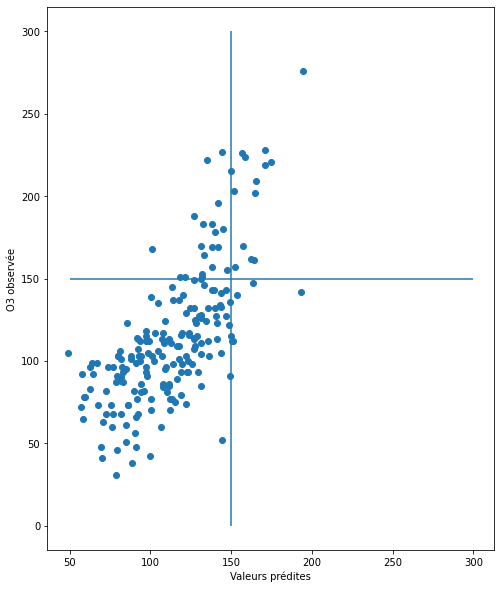

In [38]:
plt.plot(prev,Yr_test,"o")
plt.xlabel(u"Valeurs prédites")
plt.ylabel(u"O3 observée")
plt.hlines(150,50,300)
plt.vlines(150,0,300)
plt.show()

In [39]:
# Dénombrement des erreurs par
# matrice de confusion
table=pd.crosstab(prev>150,Yr_test>150)
print(table)

O3obs  False  True 
row_0              
False    162     20
True       5     13


**Q** Observer l'asymétrie de cette matrice. A quoi est-elle due au moins en partie ?

*Scikit-learn* propose d'autres procédures d'optimisation du paramètre de régularisation lasso par validation croisée en régression; `lassoCV` utilise un algorithme de *coordinate descent*, sans calcul de dérivée puisque la norme *l1* n'est pas dérivable, tandis que `lassoLarsCV` est basée sur l'algorithme de *least angle regression*. Ces fonctions permettent de tracer également les *chemins de régularisation*. Voici l'exemple de `lassoCV` qui offre plus d'options.

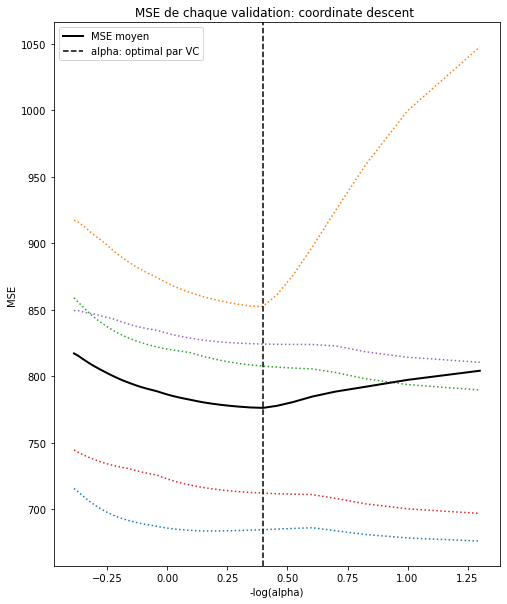

In [40]:
from sklearn.linear_model import LassoCV, LassoLarsCV
model = LassoCV(cv=5, alphas=np.array(range(1,50,1))/20.,n_jobs=-1,random_state=13).fit(Xr_train,Yr_train)
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
# ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='MSE moyen', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: optimal par VC')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('MSE')
plt.title('MSE de chaque validation: coordinate descent ')
plt.show()

**Q** Vérifier que c'est bien la même valeur optimale que celle précédemment trouvée.

Tracés des chemins de régularisation.

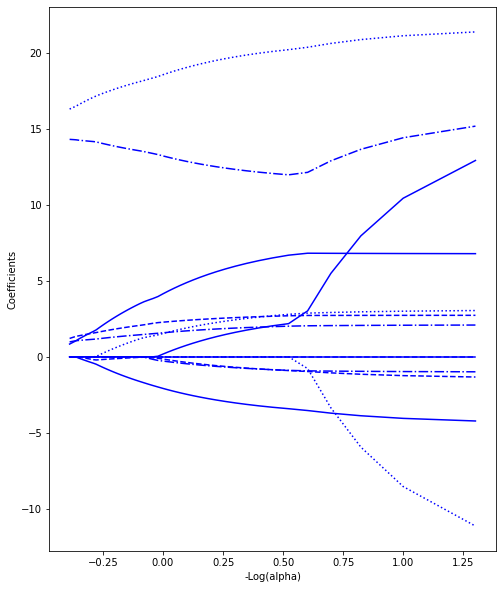

In [41]:
from itertools import cycle

from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(Xr_train,Yr_train, alphas=np.array(range(1,50,1))/20.,)


plt.figure()
ax = plt.gca()

styles = cycle(['-', '--', '-.', ':'])

neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, s in zip(coefs_lasso, styles):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, linestyle=s,c='b')
plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
plt.show()

#### [Régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf) ou modèle binomial

La même démarche est déroulée mais en modélisant directement la variable binaire Yb de dépassement ou non du seuil. Il s'agit d'une régression logistique avec toujours une pénalisation Lasso pour opérer une sélection de variables.

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[1,1.2,1.5,1.7,2,3,4]}]
logit = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt=logit.fit(Xr_train, Yb_train)  # GridSearchCV est lui même un estimateur
# paramètre optimal
logitOpt.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt.best_score_,logitOpt.best_params_))

Meilleur score = 0.120132, Meilleur paramètre = {'C': 1.5}


In [44]:
# erreur sur l'échantillon test
1-logitOpt.score(Xr_test, Yb_test)

0.11499999999999999

Le modèle "optimal"  obtenu est utilisé pour prédire l'échantillon test et estimer ainsi, sans biais, une erreur de prévision. 

La matrice de confusion croise les dépassements de seuils prédits avec ceux effectivement observés. 

In [45]:
# Prévision
y_chap = logitOpt.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         162  18
1           5  15


L'interprétation du modèle est basée sur les valeurs des coefficients avec les mêmes difficultés ou restrictions que pour la régression. Attention, `GridSearch` ne retient pas les coefficients, il faut les ré-estimer.

In [46]:
# Coefficients
logitLasso=LogisticRegression(penalty="l1",C=logitOpt.best_params_['C'],
                              solver="liblinear")
logitCoef=logitLasso.fit(Xr_train,Yb_train).coef_
print(logitCoef[0])

[ 0.          0.         -0.21867978  0.11237998  0.7435824  -0.32310367
  0.24424553  2.15276958 -0.5489172   0.02747495  0.57653579  1.00289607
 -0.88745431]


In [47]:
coef = pd.Series(logitCoef[0], index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 11 variables et en supprime 2


Text(0.5, 1.0, 'Coefficients du modèle lasso')

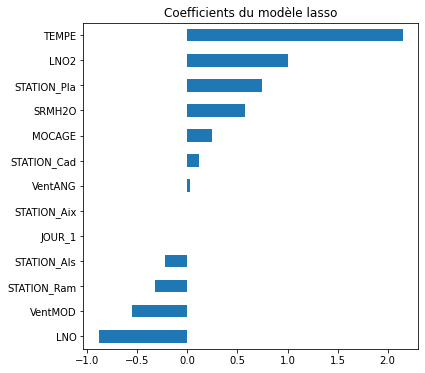

In [48]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

**Q** Interpréter l'effet des variables retenues.

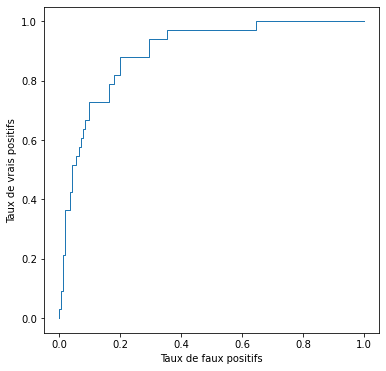

In [49]:
from sklearn.metrics import roc_curve
probas_ = LogisticRegression(penalty="l1", solver="liblinear",
                    C=logitOpt.best_params_['C']).fit(X_train, Yb_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Yb_test, probas_[:,1])
plt.plot(fpr, tpr, lw=1)
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.show()

**Q** Commenter la courbe ROC à propos du choix de la valeur seuil.

# <FONT COLOR="Red">Épisode 2</font>

### [K plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf)

Voici un cas d'application d'analyses discriminantes [non paramétriques](http://scikit-learn.org/stable/modules/neighbors.html), celles [paramétriques](http://scikit-learn.org/stable/modules/lda_qda.html) (gaussienes) linéaires et quadratiques sont également présentes dans *scikit-learn* mais laissées en exercice.

Le paramètre de compléxité ($k$) est optimisé sur une grille prédéfinie en minimisant l'erreur estimée par validation croisée; scikit-learn propose de nombreuses options de validation croisée. 

In [50]:
from sklearn.neighbors import KNeighborsClassifier
# Optimisation de k
# grille de valeurs
param_grid=[{"n_neighbors":list(range(1,15))}]
knn=GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knnOpt=knn.fit(Xr_train, Yb_train)  # GridSearchCV est lui même un estimateur
# paramètre optimal
knnOpt.best_params_["n_neighbors"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-knnOpt.best_score_,knnOpt.best_params_))

Meilleur score = 0.116568, Meilleur paramètre = {'n_neighbors': 7}


In [51]:
# Estimation de l'erreur de prévision sur l'échantillon test
1-knnOpt.score(Xr_test,Yb_test)

0.11499999999999999

In [52]:
# Prévision de l'échantillon test
y_chap = knnOpt.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         163  19
1           4  14


**Exercice** Compléter les résultats en utilisant la fonction [KNeighborsRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) pour modéliser la concentration; optimiser $k$, calculer la prévision de l'échantillon test, tracer le graphe des résidus, calculer le MSE sur l'échantillon test.

### [Arbre binaire de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf)

Les [arbres binaires de décision](http://scikit-learn.org/stable/modules/tree.html) : discrimination ou régression, sont bien implémentés dans *scikit-learn* mais avec une insuffisance pour leur élagage. Ce n'est pas une *pénalisation* de la *complexité*, et donc précisément le nombre de feuilles qui est optimisé, mais la profondeur globale de l'arbre au risque d'élaguer, à une profondeur donnée, des feuilles importantes ou de conserver des feuilles ambigües.

Comme précédemment, la validation croisée permet d'optimiser le paramètre sur une grille.

In [53]:
from sklearn.tree import DecisionTreeClassifier
# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,10))}]
tree= GridSearchCV(DecisionTreeClassifier(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(Xr_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))

Meilleur score = 0.141555, Meilleur paramètre = {'max_depth': 2}


In [54]:
# Estimation de l'erreur de prévision
1-treeOpt.score(Xr_test,Yb_test)

0.15500000000000003

In [64]:
# prévision de l'échantillon test
y_chap = treeOpt.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         162  26
1           5   7


Autre difficulté dans la représentation d'un arbre de décision binaire. Le logiciel conseillé (Graphviz) semble délicat d'installation et d'utilisation pour un néophyte. Il est possible de lister la construction des noeuds avec quelques [lignes de commande.](http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)

In [70]:
from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
from six import StringIO
import pydotplus
treeG=DecisionTreeClassifier(max_depth=treeOpt.best_params_['max_depth'])
treeG.fit(Xr_train,Yb_train)
dot_data = StringIO() 
export_graphviz(treeG, out_file=dot_data) 
graph=pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("treeOpt.png")  

True

In [71]:
from IPython.display import Image
Image(filename='treeOpt.png')µ

SyntaxError: invalid syntax (<ipython-input-71-0dc81400d53f>, line 2)

**Q** Que dire de l'interprétation de l'arbre? Comparer les rôles des variables avec le modèle logit.

**Exercice** Compléter les résultats en utilisant la fonction [DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) pour modéliser concentration; optimiser la profondeur, calculer la prévision de l'échantillon test, tracer les résidus, calculer le MSE sur l'échantillon test.

# <FONT COLOR="Red">Épisode 3</font>

### [Réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf)

Les réseaux neuronaux (perceptron multicouche) ne sont présents dans le package `Scikit-learn` qu'à partir de la version 0.18. Les méthodes *profondes* (*deep learning*) nécessitent l'installation des librairies [*theano*](http://deeplearning.net/software/theano/) et [*Lasagne*](http://lasagne.readthedocs.io/en/latest/index.html) ou [*theano*](http://deeplearning.net/software/theano/), [*TensorFlow*](https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html) et [*Keras*](https://keras.io/). Ces dernières sont nettement plus complexes à installer, surtout sous Windows. Elles feront l'objet d'un autre tutoriel.

In [72]:
from sklearn.neural_network import MLPClassifier

Définition des paramètres dont le nombre de neurones et `alpha` qui règle la régularisation par défaut 10-5. Le nombre de neurones est optimisé mais ce peut être `alpha` avec un nombre grand de neurones. Le nombre max d'itérations par défaut (200) semble insuffisant. Il est fixé à 500.

In [73]:
param_grid=[{"hidden_layer_sizes":list([(5,),(6,),(7,),(8,)])}]
nnet= GridSearchCV(MLPClassifier(max_iter=500),param_grid,cv=10,n_jobs=-1)
nnetOpt=nnet.fit(Xr_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - nnetOpt.best_score_,nnetOpt.best_params_))

Meilleur score = 0.109454, Meilleur paramètre = {'hidden_layer_sizes': (7,)}


In [74]:
# Estimation de l'erreur de prévision sur le test
1-nnetOpt.score(Xr_test,Yb_test)

0.125

In [75]:
# prévision de l'échantillon test
y_chap = nnetOpt.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         157  15
1          10  18


**Exercice** Remplacer ensuite la fonction MLPClassifier par celle [MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) de régression. Optimiser le paramètre, calculer la prévision, les résidus, le MSE.

### [Forêts aléatoires](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

La librairie *randomForest* de R utilise le programme historique développé par [Breiman et Cutler](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_software.htm)(2001) et interfacé  par [Liaw et Wiener](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf). Cette interface est toujours mise à jour mais il n'est pas sûr que le programme original continue d'évoluer depuis 2004. Pour des tailles importantes d'échantillons, quelques milliers, cette implémentation atteint des temps d'exécution rédhibitoires (cf. cet [exemple](https://github.com/wikistat/Ateliers-Big-Data/blob/master/2-MNIST/Atelier-MNIST-R.ipynb)) au contraire de celle en Python dont gestion mémoire et capacité de parallélisation ont été finement optimisées par [Louppe et al.](http://fr.slideshare.net/glouppe/accelerating-random-forests-in-scikitlearn)(2014). 

De même que le boosting, deux fonctions  de forêt sont proposés dans [scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html) ; une pour la régression et une pour la classification ainsi qu'une version "plus aléatoire". Par rapport à la version originale de R, moins d'options sont proposées mais l'utilisation de base est très similaire avec le même jeu de paramètres.

**Q20** Identifier les paramètres, les valeurs par défaut.

In [76]:
from sklearn.ensemble import RandomForestClassifier 
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, 
   criterion='gini', max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(Xr_train,Yb_train)
print(1-rfFit.oob_score_)

0.1141498216409037


Comparer l'erreur out-of-bag ci-dessus avec celle sur l'échantillon test.

In [77]:
# erreur de prévision sur le test
1-rfFit.score(Xr_test,Yb_test)

0.10499999999999998

Optimisation par validation croisée du nombre de variables tirés aléatoirement lors de la construction de chaque noeud. 

In [78]:
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestClassifier(n_estimators=100),
        param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xr_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.111806, Meilleur paramètre = {'max_features': 2}


Plusieurs exécutions, rendues aléatoires par la validation croisée, peuvent conduire à des valeurs "optimales" différentes de ce paramètre sans pour autant nuire à la qualité de prévision sur l'échantillon test.

In [79]:
# erreur de prévision sur le test
1-rfOpt.score(Xr_test,Yb_test)

0.10999999999999999

**Exercice** Tester différentes valeurs de *min_samples_split* de celle trouvée optimale. Conclusion sur la sensibilité de l'optimisation de ce paramètre ?

In [80]:
# prévision
y_chap = rfFit.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         165  19
1           2  14


Comme avec R, il est possible de calculer un indicateur d'importance des variables pour aider à une forme d'interprétation. Celui-ci dépend de la position de la variable dans l'arbre et correspond donc au *mean decrease in Gini index* de R plutôt qu'au *mean descrease in accuracy*. La forêt doit être réestimée car GridSearch ne connaît pas le paramètre d'importance.

In [81]:
rf= RandomForestClassifier(n_estimators=100,max_features=2)
rfFit=rf.fit(Xr_train, Yb_train)
# Importance décroissante des variables
importances = rfFit.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(Xr_train.shape[1]):
    print(dfC.columns[indices[f]], importances[indices[f]])

TEMPE 0.257098785538183
MOCAGE 0.17051740837244025
SRMH2O 0.12170636042926822
VentANG 0.10581497803746104
LNO 0.09141712408424342
LNO2 0.09043027359324374
VentMOD 0.08840232897756906
STATION_Cad 0.02097688922589695
STATION_Pla 0.014008503917594858
JOUR_1 0.011709471861391282
STATION_Als 0.011076771904609055
STATION_Aix 0.009683123988903728
STATION_Ram 0.0071579800691953825


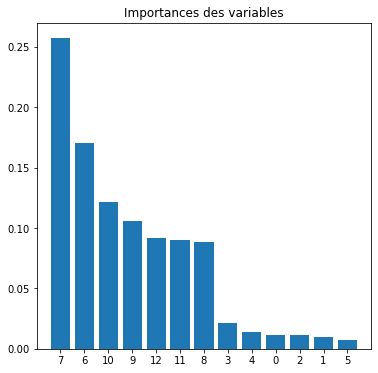

In [82]:
# Graphe des importances
plt.figure()
plt.title("Importances des variables")
plt.bar(range(Xr_train.shape[1]), importances[indices])
plt.xticks(range(Xr_train.shape[1]), indices)
plt.xlim([-1, Xr_train.shape[1]])
plt.show()

**Q** Comparer les importances des variables et les sélections opérées précédemment. 

**Exercice** Remplacer ensuite la fonction RandomForestClassifier par celle [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) de régression. Optimiser le paramètre, calculer la prévision, les résidus, le MSE.

**Exercice** Expérimenter également le boosting sur ces données en exécutant la fonction [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) opérant l'agorithme de *gradient tree boosting*. 

**Remarque:** Une version "améliorée" de *boosting* mieux paralélisée et incluant d'autres paramètres (pénalisation), est  proposé dans le package: [`XGBoost`](https://xgboost.readthedocs.io/en/latest/build.html#python-package-installation) qui peut être utilisé à partir de Python mais aussi R, Julia ou Java. Nénamoins le choix est fait d'arrêter l'acharnement sur ces données; `XGBoost` est testé en python sur un autre jeu de données. 

# <FONT COLOR="Red">Épisode 4</font>

### [*Support Vector Machine*](http://wikistat.fr/pdf/st-m-app-svm.pdf)

De nombreux paramètres sont associés à cette méthode. La liste est à consulter dans la [documentation](http://scikit-learn.org/stable/modules/svm.html) en ligne.

L'optimisation de la pénalisation (paramètre C) est recherchée sur une grille par validation croisée. Remarque: il serait nécessaire d'optimiser également la valeur du coefficient *gamma* lié au noyau gaussien ("écart-type").

Il est souvent nécessaire de normaliser des données avant d'opérer les SVM.

In [83]:
from sklearn.svm import SVC
param=[{"C":[0.4,0.5,0.6,0.8,1,1.4]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xr_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.107059, Meilleur paramètre = {'C': 0.8}


In [84]:
# erreur de prévision sur le test
1-svmOpt.score(Xr_test,Yb_test)

0.125

In [85]:
# prévision de l'échantillon test
y_chap = svmOpt.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         162  20
1           5  13


**Exercice** Comme précédemment, remplacer ensuite la fonction SVC par celle [SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) de régression. Optimiser le paramètre, calculer la prévision, les résidus; le MSE.

## Synthèse: comparaison des méthodes

### Courbes ROC

Dans toute méthode, la prévision de dépassement ou non est associée au choix d'un seuil qui est par défaut 0.5. L'optimisaiton de ce seuil dépend des coûts respectifs associés aux faux positifs et aux faux négatifs qui ne sont pas nécessairement égaux. La courbe ROC permet de représenter l'influence de ce seuil sur les taux de faux positifs et vrais positifs.  

In [86]:
from sklearn.metrics import roc_curve
listMethod=[["RF",rfOpt],["NN",nnetOpt],["Tree",treeOpt],["K-nn",knnOpt],["Logit",logitOpt]]

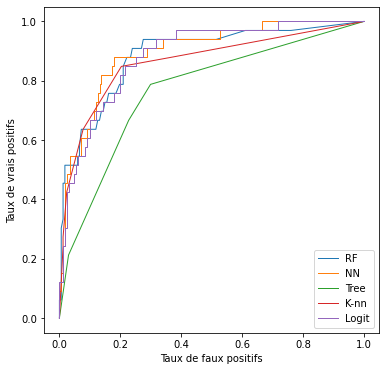

In [87]:
for method in enumerate(listMethod):
    probas_ = method[1][1].fit(Xr_train, Yb_train).predict_proba(Xr_test)
    fpr, tpr, thresholds = roc_curve(Yb_test, probas_[:,1])
    plt.plot(fpr, tpr, lw=1,label="%s"%method[1][0])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend(loc="best")
plt.show()

**Q22** Le critère d'AUC (aire sous la courbe) permet-il d'ordonner les courbes et donc les méthodes? 

C'est à un taux de faux positif admissible et donc à valeur de seuil fixé qu'il faut choisir la méthode d'apprentissage à privilégier. 

### Itération sur plusieurs échantillons de test ([validation croisée *Monte Carlo*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf))

L'échantillon test est de taille modeste et donc l'estimation de l'erreur de prévision peut présenter une variance importante. Celle-ci est réduite en opérant une forme de validation croisée (*Monte Carlo*) en tirant plusieurs couples d'échantillon apprentissage et test pour itérer les traitements précédents. Les données sont normalisées pour toutes les méthodes car les autres que SVM et NN ne sont pas affectées.

Les fonctionnalités de scikit-learn se prètent bien à l'automatisation de ces traitements enchaînant extraction d'échantillons, estimation de plusieurs modèles, optimisation de leurs paramètres et estimation de l'erreur de prévision sur le test.

Le code est compact et d'exécution efficace car bien parallélisé par les fonctions utilisées.

In [88]:
from sklearn.utils import check_random_state
import time
check_random_state(13)
tps0=time.perf_counter()
# définition des estimateurs
logit= LogisticRegression(penalty="l1",solver="liblinear")
knn  = KNeighborsClassifier()
tree = DecisionTreeClassifier()
nnet = MLPClassifier(max_iter=600)
rf   = RandomForestClassifier(n_estimators=100)
svm  = SVC()
# Nombre d'itérations
B=3 # pour exécuter après le test, mettre plutôt B=30
# définition des grilles de paramètres
listMethGrid=[[svm,{"C":[0.4,0.5,0.6,0.8,1,1.4]}],
    [rf,{"max_features":list(range(2,10,2))}],
    [nnet,{"hidden_layer_sizes":list([(5,),(6,),(7,),(8,)])}],
    [tree,{"max_depth":list(range(2,10))}],
    [knn,{"n_neighbors":list(range(1,15))}],
    [logit,{"C":[0.5,1,5,10,12,15,30]}]]
# Initialisation à 0 des erreurs pour chaque méthode (colonne) et chaque itération (ligne)
arrayErreur=np.empty((B,6))
for i in range(B):   # itérations sur B échantillons test
    # extraction apprentissage et test
    X_train,X_test,Yb_train,Yb_test=train_test_split(dfC,Yb,test_size=200)
    scaler = StandardScaler()  
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)  
    # Meme transformation sur le test
    X_test = scaler.transform(X_test)
    # optimisation de chaque méthode et calcul de l'erreur sur le test
    for j,(method, grid_list) in enumerate(listMethGrid):
        methodGrid=GridSearchCV(method,grid_list,cv=10,n_jobs=-1,
                               iid="TRUE").fit(X_train, Yb_train)
        methodOpt = methodGrid.best_estimator_
        methFit=methodOpt.fit(X_train, Yb_train)
        arrayErreur[i,j]=1-methFit.score(X_test,Yb_test)
tps1=time.perf_counter()
print("Temps execution en mn :",(tps1 - tps0))
dataframeErreur=pd.DataFrame(arrayErreur,columns=["SVM","RF","NN","Tree","Knn","Logit"])    

C:\Users\Joan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\Joan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\Joan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\Joan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\Joan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\Joan\anaconda3\lib\site-packages\sklearn\model_selection\_search.p

Temps execution en mn : 31.4377563999999


C:\Users\Joan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\Joan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


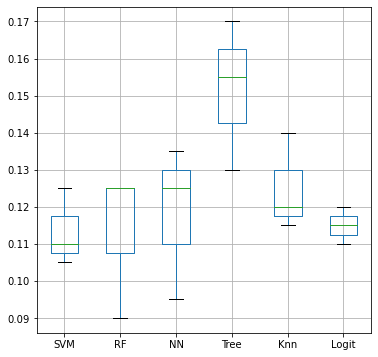

In [89]:
# Distribution des erreurs de prévisions
# Les SVM présentant des erreurs atypiques sont laissés de côté.
dataframeErreur[["SVM","RF","NN","Tree","Knn","Logit"]].boxplot(return_type='dict')
plt.show()

In [90]:
# Moyennes
dataframeErreur.mean()

SVM      0.113333
RF       0.113333
NN       0.118333
Tree     0.151667
Knn      0.125000
Logit    0.115000
dtype: float64

### Conclusion sur l'apprentissage
**Q** Quel méthode retenir? Est-ce cohérent avec les résultats e R?

Cet exemple, traité en R puis en Python, résume bien l'intérêt et le contexte des méthodes d'apprentissage.
* Par rapport à la *base line* : prévision MOCAGE présentant un taux moyen d'erreur de 30%, un modèle statistique élémentaire améliore très sensiblement le résultat.
* Une méthode plus sophistiquée, ici *SVM* ou *random forest* apporte une amélioration statistiquement significative mais assez faible au prix de l'interprétation fine des résultats fournie par une régression logistique.
* Python, outil d'*apprentissage machine*, est plus efficace que R pour les  simulations.
* En revanche, R, outil d'*apprentissage statistique*, permet la sélection et l'interprétation des variables et de leurs **interactions** pour un modèle de régression linéaire ou logistique classique. La prise en compte d'interactions (modèle quadratique) améliore sensiblement la qualité des prévisions.
* Les forêts aléatoires et les SVM font mieux sur cet exemple, c'est souvent le cas comme avec le *boosting*, mais d'autres exemples mettent en avant d'autres méthodes: neurones pour une modélisation physique, SVM pour du criblage virtuelle de molécules, régression PLS pour la spectrométrie en proche infra-rouge (NIR)... pas de règle générale.
* Jupyter est un support pédagogique efficace pour des analyses sans développement volumineux de code.
* Avant d'éventuellement passer à [Julia](http://julialang.org/), R et Python sont à l'usage très complémentaires.


# <FONT COLOR="Red">Épisode 5</font>
**Remarque** Il est possible d'exécuter directement l'*épisode 5* sans passer par toutes les étapes de classification supervisée. Il suffit d'exécuter jusqu'à la *section 4.1* de l'*épidode 1*, phase exploratoire et préparation des échantillons, afin de construire les données utilisées dans les sections 12 et 13 d'imputation des données manquantes et de détection d'atypiques.

## [Gestion des données manquantes](http://wikistat.fr/pdf/st-m-app-idm.pdf)
Les vraies données sont le plus souvent mitées par l'absence de données, conséquences d'erreurs de saisie, de pannes de capteurs... Les librairies de Python (`pandas`) offrent des choix rudimentaires pour faire des imputations de données manquantes quand celles-ci le sont de façon complètement aléatoire. 

Le [calepin R](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-R-Ozone.ipynb) d'analyse de ces mêmes données propose une comparaison assez détaillée de deux stratégiées afin d'évaluer leurs performances respectives. 

La **première stratégie** commence par imputer les données manquantes en les prévoyant par l'algorithme `missForest`. Une fois les données manquantes imputées, différentes méthodes de prévision sont utilisables comme précédemment. Deux sont exécutées: forêts aléatoires et *extrem gradient boosting*.

La **deuxième stratégie** évite l'étape d'imputation en exécutant directement un algorithme de prévision tolérant des données manquantes. Peu le fond, c'est le cas de `XGBoost`.

Sur ces données, mais sans gros effort d'optimisation de `XGBoost`, la première stratégie enchaînant `missForest` puis `randomForest` conduit à de meilleurs résultats. Seule celle-ci est employée dans ce calepin mais, bien évidemment, l'exécution de `xgboost` sans imputation préalable est une option également possible en Python.

Bien moins de méthodes sont proposées en Python, `SCikit-learn` ne proposant que des imputations basiques par la moyenne ou la médiane comme dans `pandas`. Néanmoins une imputation par prévision utilisant *k*-n, l'ACP ou des forêts aléatoires est disponible dans la librairie `predictive_imputer`.

Les commandes ci-dessous font appel aux fichiers suivants:
- `X` données complètes initiales 
- `Xna` les données avec des trous, 
- `XnaImp` les données avec imputations 


### Préparation des trous dans `ozone`
Les données initiales de la base `ozone` sont reprises. Seule la variable à expliquer de dépassement de seuil est conservée. La première opération consiste à générer aléatoirement un certain taux de données manquantes par la fonction définie ci-dessous.

In [91]:
import numpy as np
import numpy.ma as ma
import random

def input_nan(x, tx):
    """
    x : a 2D matrix of float dtype
    tx: the rate of nan value to put in the matrix
    """
    n_total = x.shape[0] * x.shape[1]
    mask = np.array([random.random() for _ in range(n_total)]).reshape(x.shape)<tx
    mx = ma.masked_array(x, mask=mask, fill_value=np.nan)
    return mx.filled()

In [92]:
# données initiales avec 
X=dfC 
# Génération de 10% de valeurs manquantes
Xna=input_nan(X, .1)

### Imputation par `missForest`
Le même algorithme que celui présent dans la librairie de R `MissForest` est implémenté dans la librairie `Scikit-learn`. 

In [95]:
from predictive_imputer import predictive_imputer
# Choix du mode de prévision par *k*-pp, ACP ou forêt aléatoire
imputer = predictive_imputer.PredictiveImputer(f_model="RandomForest")
# Imputation
XnaImp = imputer.fit(Xna).transform(Xna.copy())

ImportError: cannot import name 'Imputer' from 'sklearn.preprocessing' (C:\Users\Joan\anaconda3\lib\site-packages\sklearn\preprocessing\__init__.py)

### Séparation des échantillons
Des cas sont consiédérés: les données sans données manquantes et les données après imputation des données manquantes. Les mêmes échantillons sont considérés en utilisant la même initialisation du générateur.

In [ ]:
# Données sans trous
X_train,X_test,Yb_train,Yb_test=train_test_split(X,Yb,test_size=200,random_state=11)
XnaImp_train,XnaImp_test,Yb_train,Yr_test=train_test_split(XnaImp,Yb,test_size=200,random_state=11)

### Prévision par forêt aléatoire
Prévision du dépassement d'ozone sans données manquantes et avec données manquantes imputées. Comparaison des erreurs de prévision sur l'échantillon test. Les valeurs par défaut des paramètres sont conservées. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
# prévision sans trous
forest = RandomForestClassifier(n_estimators=500)
# apprentissage
rfFit = forest.fit(X_train,Yb_train)
# erreur de prévision
# erreur de prévision sur le test
1-rfFit.score(X_test,Yb_test)

In [ ]:
# prévision avec trous imputés
forest = RandomForestClassifier(n_estimators=500)
# apprentissage
rfFit = forest.fit(XnaImp_train,Yb_train)
# erreur de prévision
# erreur de prévision sur le test
1-rfFit.score(XnaImp_test,Yb_test)

**Q** Que dire de la qualité de prévision avec 10% de trous

**Exercice** Faire varier le taux de trous et étudier la dégradation de la prévision.

**Exercice** Comparer avec une approche directe de la prévision avec `XGBoost` sans imputation préalable.

# <FONT COLOR="Red">Épisode 5 bis</font>
**Remarque** Il est possible d'exécuter directement l'*épisode 5* sans passer par toutes les étapes de classification supervisée. Il suffit d'exécuter jusqu'à la *section 4.1* de l'*épidode 1*, phase exploratoire et préparation des échantillons, afin de construire les données utilisées dans les sections 6 et 7 d'imputation des données manquantes et de détection d'atypiques.
## Détection d'observations atypiques

Le [calepin R](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-R-Ozone.ipynb) d'analyse de ces mêmes données propose une comparaison assez détaillée des scores de détection des anomalies. Comme dans R, `Scikit-learn` propose des fonctions en Pyhton de détection d'atypiques multidimensionnels. Les principales sont *LOF* et *Isolation Forest* dont les résultats sont comparés ci-dessous.


### *Local Outlier Factor*
Les données sont restreintes aux seules variables quantitatives explicatives.

**Q** Quel est le rôle du paramètre *k* ci-dessous?

In [ ]:
ozone.head()

In [ ]:
ozoneR=ozone[["MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]]
ozoneR.head()

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.05 ) # choix de n_n par défaut
scoreLOF=clf.fit_predict(ozoneR)
scoreAtyp=-clf._decision_function(ozoneR)# opposé du LOF
plt.boxplot(scoreAtyp)
plt.show()

**Q** Comment se comporte le *LOF* en fonction de *k*?

**Q** Quel taux d'observations par défaut sont considérées comme atypiques?

In [ ]:
atypLofInd = clf.fit_predict(X)

L'analyse en composante principale est utilisée pour représenter les observations atypiques.

In [ ]:
## Repésentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypLofInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

### *OCC SVM*
**Q** Quels sont les paramètres de cette fonction.

In [ ]:
from sklearn.svm import OneClassSVM
clf=OneClassSVM(nu=0.1, gamma=0.01)
scoreSVM=clf.fit(ozoneR)
scoreAtypSVM=clf._decision_function(ozoneR)
plt.boxplot(scoreAtypSVM)
plt.show()

**Q** Quel taux d'atypiques par défaut?

In [ ]:
atypSVMInd = clf.predict(ozoneR)

In [ ]:
## Repésentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypSVMInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

### *Isolation forest*
**Q** Comment se mesure l"atypicité" d'une observation dans le cas d'*isolation forest*?

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=1000, contamination=0.05,behaviour="new")
scoreIF=clf.fit(ozoneR)
scoreAtypIF=clf.decision_function(ozoneR)
plt.boxplot(scoreAtypIF)
plt.show()

In [ ]:
atypIFInd = clf.predict(ozoneR)
## Repésentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypIFInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

**Q** Les observations définies comme des anomalies se retrouve-t-elles généralement d'une approche à l'autre?

**Remarques**

- la littérature sur la détection d'anomalies ou de nouveautés multidimensionnelles est vaste et fort peu consensuelle. Ceci est encore renforcé par le fait qu'il est difficile de définir un critère efficace de mesure de la qualité d'une détection. Voir à ce sujet l'[article](http://www.dbs.ifi.lmu.de/research/outlier-evaluation/) de Campos et al. (2016).  Il importe donc, en fonctin du cas et des données traitées, de pouvoir disposer d'une "vérité terrain": quelle méthode est le pllus susceptible de retrouver des anomalies identifiées en tant que telle?
- Conrairement à la librairie originale `randomForest` de R, il ne semble pas exister de librairie proposant la détection d'anomalies relativemement à la construction d'un modèle de prévision *y=f(X)* par forêt aléatoire. Il importe de suivre l'évolution des librairies en cours de développement.